## Generate data
We use valve equation to come up with a dataset that we will later use for regression.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# define a function for valve equation
def valve_flow(dp, op, k):
    
    print('Starting flow calculation for dp='+ str(dp), ', op='+ str(op)+', k='+str(k))
    q = op * k * np.sqrt(dp)
    print('Calculation finished')
    
    return q

# generate arrays of inputs
openings = np.linspace(0, 1, 10)
dps = np.linspace(0, 200, 10)
ks = np.linspace(0, 100000, 10)

# create an empty table, and specify the column name
data = pd.DataFrame(columns=['k', 'op', 'dp', 'q'])

# go through all the possible permutations of the inputs, 
# calculate the outputs and write them in the empty table
for op in openings:
    for dp in dps:
        for k in ks:
            q = valve_flow(dp, op, k)            
            data.loc[len(data)] = [k, op, dp, q]

# write the table into a csv file
data.to_csv('valve_data.csv')

Starting flow calculation for dp=0.0 , op=0.0, k=0.0
Calculation finished
Starting flow calculation for dp=0.0 , op=0.0, k=11111.111111111111
Calculation finished
Starting flow calculation for dp=0.0 , op=0.0, k=22222.222222222223
Calculation finished
Starting flow calculation for dp=0.0 , op=0.0, k=33333.333333333336
Calculation finished
Starting flow calculation for dp=0.0 , op=0.0, k=44444.444444444445
Calculation finished
Starting flow calculation for dp=0.0 , op=0.0, k=55555.555555555555
Calculation finished
Starting flow calculation for dp=0.0 , op=0.0, k=66666.66666666667
Calculation finished
Starting flow calculation for dp=0.0 , op=0.0, k=77777.77777777778
Calculation finished
Starting flow calculation for dp=0.0 , op=0.0, k=88888.88888888889
Calculation finished
Starting flow calculation for dp=0.0 , op=0.0, k=100000.0
Calculation finished
Starting flow calculation for dp=22.22222222222222 , op=0.0, k=0.0
Calculation finished
Starting flow calculation for dp=22.22222222222222

## Import data and visualise 

In [2]:
# import the data 
my_data = pd.read_csv('valve_data.csv')

In [3]:
# visualise the data
import plotly.express as px
fig = px.scatter_3d(my_data, x="op", y="dp", z="q", color="k")
fig.show()

## Preprocess data

In [4]:
# we borrow some preprocessing tools from sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

We usually `preprocessing` from `sklearn` to normalise the data. However, here we just normalise them manually by dividing the original values with the largest value in that column.

In [5]:
# define and preprocess input data
X = pd.DataFrame(columns=['op', 'k', 'dp'])
X['op'] = my_data['op'] / 1
X['k'] = my_data['k'] / 100000
X['dp'] = my_data['dp'] / 200
X

,op,k,dp
0,0.0,0.000000,0.0
1,0.0,0.111111,0.0
2,0.0,0.222222,0.0
3,0.0,0.333333,0.0
4,0.0,0.444444,0.0
...,...,...,...
995,1.0,0.555556,1.0
996,1.0,0.666667,1.0
997,1.0,0.777778,1.0
998,1.0,0.888889,1.0


In [6]:
# do the same for output data
y = my_data['q'] / 1.414e6
y

0      0.000000
1      0.000000
2      0.000000
3      0.000000
4      0.000000
         ...   
995    0.555639
996    0.666767
997    0.777895
998    0.889023
999    1.000151
Name: q, Length: 1000, dtype: float64

In [7]:
# split and randomise data using train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Build neural network and train it

In [8]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense

In [9]:
# configure some settings that we will use for model training later
my_optimizer = keras.optimizers.Adam(learning_rate=0.01)
my_metric = tf.keras.metrics.MeanAbsoluteError()

In [10]:
# configure and build the neural network
model = Sequential()
model.add(Dense(5, input_dim=3, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='mae', optimizer=my_optimizer, metrics=my_metric)

In [11]:
# train the model, 
# we assign the output to "history" so that we can monitor it's performance history
history = model.fit(X_train, y_train, verbose=1, epochs=2000, validation_split=0.2)

Epoch 1/2000
20/20 [==============================] - 1s 13ms/step - loss: 0.3256 - mean_absolute_error: 0.3256 - val_loss: 0.2301 - val_mean_absolute_error: 0.2301
Epoch 2/2000
20/20 [==============================] - 0s 4ms/step - loss: 0.1904 - mean_absolute_error: 0.1904 - val_loss: 0.1715 - val_mean_absolute_error: 0.1715
Epoch 3/2000
20/20 [==============================] - 0s 4ms/step - loss: 0.1541 - mean_absolute_error: 0.1541 - val_loss: 0.1568 - val_mean_absolute_error: 0.1568
Epoch 4/2000
20/20 [==============================] - 0s 3ms/step - loss: 0.1468 - mean_absolute_error: 0.1468 - val_loss: 0.1531 - val_mean_absolute_error: 0.1531
Epoch 5/2000
20/20 [==============================] - 0s 3ms/step - loss: 0.1439 - mean_absolute_error: 0.1439 - val_loss: 0.1510 - val_mean_absolute_error: 0.1510
Epoch 6/2000
20/20 [==============================] - 0s 3ms/step - loss: 0.1423 - mean_absolute_error: 0.1423 - val_loss: 0.1491 - val_mean_absolute_error: 0.1491
Epoch 7/2000
20

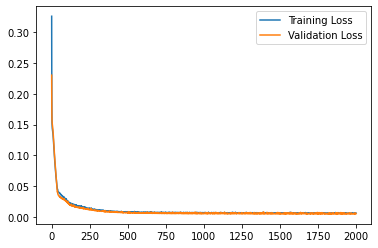

In [12]:
#%% plot loss
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()

## Check neural network performance

In [13]:
# use the trained model to predict y given X for train and test dataset
predicted_y_train = model.predict(X_train)
predicted_y_test = model.predict(X_test)

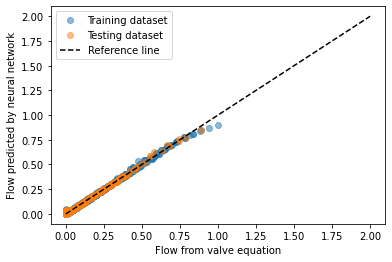

In [14]:
plt.figure()
plt.plot(y_train, predicted_y_train,'o', alpha=0.5, label='Training dataset')
plt.plot(y_test, predicted_y_test,'o', alpha=0.5, label='Testing dataset')
plt.plot([0,2],[0,2],'--k', label='Reference line') # 45 degree reference line
plt.xlabel('Flow from valve equation')
plt.ylabel('Flow predicted by neural network')
plt.legend()

Get the trained neural network weights and biases. Try to implement the neural network with these wights and biases in Excel.

In [15]:
model.get_weights()

[array([[ 2.7784592e-01,  1.5339557e+00, -4.6231775e+00, -2.7343748e+00,
         -2.6733658e-01],
        [ 2.8700131e-01,  1.6105114e+00, -1.7643575e-01, -2.7475262e+00,
         -4.5701747e+00],
        [ 4.5830717e+00, -4.6537891e+01, -1.9405037e-02, -1.4969444e+00,
         -3.5259819e-03]], dtype=float32),
 array([-0.0659168, -2.0429869, -1.0955797,  6.8850455, -1.0739324],
       dtype=float32),
 array([[  2.7752483],
        [-18.208889 ],
        [-12.428195 ],
        [ -5.576825 ],
        [-12.889669 ]], dtype=float32),
 array([2.108374], dtype=float32)]